<a href="https://colab.research.google.com/github/SwatiNeha/neural-networks-applied/blob/main/Distribution%20Mapping%20Using%20Diffusion%20Processes%20SDE%20and%20ODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Distribution Mapping Using Diffusion Processes : SDE's and ODE's**

In [ ]:
import numpy as np
import plotly.express as px
import torch
import torch.nn as nn
import torch.optim as optim
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

***1.*** ***Defining Functions for generating samples for uniform distribution of dogs, cats and Gaussian distribution***

In [ ]:
amplify = 1
offset = 0
# Function to generate uniform distribution for dogs
def sample_dogs(n, amplify=1, offset=0):
    corner1 = np.array([2, 2])
    corner2 = np.array([3, 3])
    data = np.random.uniform(corner1, corner2, (n, 2))
    data = data * amplify + offset
    return torch.tensor(data, dtype=torch.float32)

# Function to generate uniform distribution for cats
def sample_cats(n, amplify=1, offset=0):
    corner1 = np.array([2, -3])
    corner2 = np.array([3, -2])
    data = np.random.uniform(corner1, corner2, (n, 2))
    data = data * amplify + offset
    return torch.tensor(data, dtype=torch.float32)

# Function to generate Gaussian distribution
def sample_gaussians(n, s=1, amplify=1, offset=0):
    mean = np.array([0, 0])
    cov = s * np.identity(2)  # Scaled identity covariance matrix
    data = np.random.multivariate_normal(mean, cov, n)
    data = data * amplify + offset
    return torch.tensor(data, dtype=torch.float32)

***2.*** ***Defining all the Visualization Functions***

In [ ]:
# Visualization functions
def plot_velocity_field(model, title):
    x = np.linspace(0, 5, 20)
    y = np.linspace(-5, 5, 20)
    X, Y = np.meshgrid(x, y)

    xy = torch.tensor(np.stack([X, Y], axis=2).reshape(-1, 2), dtype=torch.float32)
    t = torch.ones(xy.shape[0], 1) * 0.5  # middle time step

    with torch.no_grad():
        velocity = model(xy, t).numpy().reshape(X.shape[0], X.shape[1], 2)

    plt.figure(figsize=(8, 8))
    plt.streamplot(X, Y, velocity[:,:,0], velocity[:,:,1], density=1, linewidth=1, arrowsize=1)
    plt.title(title)
    plt.xlim(0, 5)
    plt.ylim(-5, 5)
    plt.show()


import plotly.graph_objs as go
from plotly.subplots import make_subplots

def plot_distributions_comparison(dogs, cats, gaussians, result, title, map_name):
    # Create subplots
    fig = make_subplots(rows=1, cols=2, subplot_titles=("Original Distributions", map_name),
                        specs=[[{"type": "xy"}, {"type": "xy"}]])

    # Plot original distributions
    fig.add_trace(go.Scatter(x=dogs[:, 0], y=dogs[:, 1], mode='markers', name='Dogs', marker=dict(color='blue')), row=1, col=1)
    fig.add_trace(go.Scatter(x=cats[:, 0], y=cats[:, 1], mode='markers', name='Cats', marker=dict(color='orange')), row=1, col=1)
    fig.add_trace(go.Scatter(x=gaussians[:, 0], y=gaussians[:, 1], mode='markers', name='Gaussians', marker=dict(color='green')), row=1, col=1)

    # Plot SDE comparison
    fig.add_trace(go.Scatter(x=dogs[:, 0], y=dogs[:, 1], mode='markers', name='Original Dogs', marker=dict(color='blue', opacity=0.5)), row=1, col=2)
    fig.add_trace(go.Scatter(x=result[:, 0], y=result[:, 1], mode='markers', name=map_name, marker=dict(color='red')), row=1, col=2)

    # Update layout
    fig.update_layout(
        title=title,
        height=600,
        width=1500,
        showlegend=True
    )

    fig.update_xaxes(scaleanchor="y", scaleratio=1, row=1, col=1)
    fig.update_yaxes(scaleanchor="x", scaleratio=1, row=1, col=1)

    fig.show()

def plot_loss_curve(losses, title="Training Loss Curve"):
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        y=losses,
        mode='lines',
        name='Loss'
    ))

    fig.update_layout(
        title=title,
        xaxis_title="Epoch",
        yaxis_title="Loss",
        width=800,
        height=500
    )

    fig.show()

***3.*** ***Defining Neural Network for SDE***

In [ ]:
# Neural Network for SDE
class VelocityNet(nn.Module):
    def __init__(self, input_dim=3):  # 2 for x, 1 for t
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x, t):
        if t.dim() == 1:
            t = t.unsqueeze(1)
        xt = torch.cat([x, t], dim=1)
        return self.net(xt)

***4.*** ***Defining Euler Maruyama and training functions for SDE***

In [ ]:
def euler_maruyama(model, x0, t, dt):
    x = x0
    trajectory = [x]
    for i in range(len(t) - 1):
        drift = model(x, t[i].unsqueeze(0).expand(x.shape[0], -1))
        noise = torch.randn_like(x) * np.sqrt(dt)
        x = x + drift * dt + noise
        trajectory.append(x)
    return torch.stack(trajectory)

def train_sde(model, optimizer, n_epochs, batch_size):
    losses = []  # List to store loss values

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Sample from Gaussian and target distributions
        x0 = sample_gaussians(batch_size)
        x_target = sample_dogs(batch_size)

        # Generate trajectory
        t = torch.linspace(0, 1, 100)
        dt = t[1] - t[0]
        trajectory = euler_maruyama(model, x0, t, dt)

        # Compute loss
        loss = torch.mean((trajectory[-1] - x_target)**2)

        loss.backward()
        optimizer.step()

        losses.append(loss.item())  # Store the loss value

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')

    return losses  # Return the list of losses

***5.*** ***Training and plotting loss curve for Gaussian to Dog SDE approach***

In [ ]:
sde_model = VelocityNet()
sde_optimizer = optim.Adam(sde_model.parameters(), lr=1e-3)
print("Training SDE model (Gaussian to Dog)...")
losses = train_sde(sde_model, sde_optimizer, n_epochs=2500, batch_size=64)
plot_loss_curve(losses, "SDE Training Loss Curve- Gaussian to Dog")

Training SDE model (Gaussian to Dog)...
Epoch [100/2500], Loss: 0.5063
Epoch [200/2500], Loss: 0.2547
Epoch [300/2500], Loss: 0.2352
Epoch [400/2500], Loss: 0.1703
Epoch [500/2500], Loss: 0.1380
Epoch [600/2500], Loss: 0.1522
Epoch [700/2500], Loss: 0.1538
Epoch [800/2500], Loss: 0.1305
Epoch [900/2500], Loss: 0.1082
Epoch [1000/2500], Loss: 0.1105
Epoch [1100/2500], Loss: 0.1231
Epoch [1200/2500], Loss: 0.1317
Epoch [1300/2500], Loss: 0.1301
Epoch [1400/2500], Loss: 0.1202
Epoch [1500/2500], Loss: 0.1357
Epoch [1600/2500], Loss: 0.1117
Epoch [1700/2500], Loss: 0.1202
Epoch [1800/2500], Loss: 0.1050
Epoch [1900/2500], Loss: 0.1038
Epoch [2000/2500], Loss: 0.0944
Epoch [2100/2500], Loss: 0.1121
Epoch [2200/2500], Loss: 0.0996
Epoch [2300/2500], Loss: 0.0946
Epoch [2400/2500], Loss: 0.0942
Epoch [2500/2500], Loss: 0.1160


***6.*** ***Visualizing Results for Gaussian to Dog: SDE Distribution and Velocity Field***

In [ ]:
# Visualize results
n_samples = 5000
t = torch.linspace(0, 1, 100)
dt = t[1] - t[0]

dogs = sample_dogs(n_samples)
cats = sample_cats(n_samples)
gaussians = sample_gaussians(n_samples)


with torch.no_grad():
    sde_result = euler_maruyama(sde_model, gaussians, t, dt)[-1]



# Convert to numpy for plotting
dogs_np = dogs.numpy()
cats_np = cats.numpy()
gaussians_np = gaussians.numpy()
sde_result_np = sde_result.numpy()

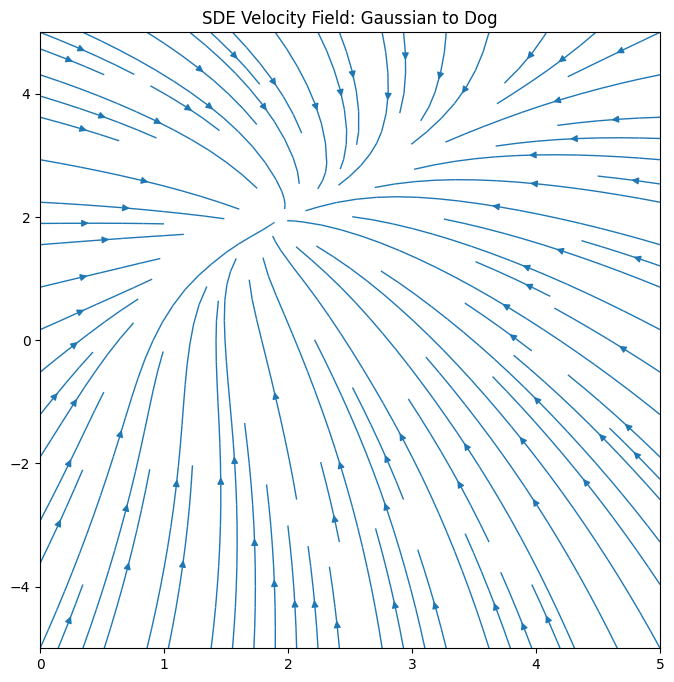

In [ ]:
plot_distributions_comparison(dogs_np, cats_np, gaussians_np, sde_result_np, 'Distribution Comparison: Original vs SDE', 'SDE: Gaussian to Dog')
plot_velocity_field(sde_model, "SDE Velocity Field: Gaussian to Dog")

***7.*** ***Defining Neural Network for ODE***

In [ ]:
# Neural Network for ODE
class VelocityNet(nn.Module):
    def __init__(self, input_dim=3):  # 2 for x, 1 for t
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.SiLU(),
            nn.Linear(256, 128),
            nn.SiLU(),
            nn.Linear(128, 64),
            nn.SiLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x, t):
        if t.dim() == 1:
            t = t.unsqueeze(1)
        xt = torch.cat([x, t], dim=1)
        return self.net(xt)

***8.*** ***Defining Euler, linear interpolation and training function for ODE***

In [ ]:

def euler_ode(model, x0, t, dt):
    x = x0
    trajectory = [x]
    for i in range(len(t) - 1):
        dx = model(x, t[i].unsqueeze(0).expand(x.shape[0], -1))
        x = x + dx * dt
        trajectory.append(x)
    return torch.stack(trajectory)


def linear_interpolation(x0, x1, t):
    t = t.view(-1, 1, 1)
    return (1 - t) * x0.unsqueeze(0) + t * x1.unsqueeze(0)

def train_ode(model, optimizer, n_epochs, batch_size, source='gaussian'):
    losses = []  # List to store loss values

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Sample from source and target distributions
        if source == 'gaussian':
            x0 = sample_gaussians(batch_size)
        elif source == 'cat':
            x0 = sample_cats(batch_size)
        x_target = sample_dogs(batch_size)

        # Generate trajectory
        t = torch.linspace(0, 1, 100)
        dt = t[1] - t[0]

        # Linear interpolation
        x_interp = linear_interpolation(x0, x_target, t)  # Shape: (100, batch_size, 2)

        # Compute velocity field
        t_expanded = t.view(-1, 1).expand(t.size(0), batch_size).reshape(-1, 1)
        x_interp_flat = x_interp.view(-1, 2)
        velocity = model(x_interp_flat, t_expanded)

        # Compute interpolation velocity
        interp_velocity = (x_interp[1:] - x_interp[:-1]) / dt.view(-1, 1, 1)
        interp_velocity_flat = interp_velocity.view(-1, 2)

        # Ensure velocity and interp_velocity_flat have the same shape
        velocity = velocity[:-batch_size]  # Remove the last batch to match interp_velocity_flat

        loss = torch.mean((velocity - interp_velocity_flat)**2)

        loss.backward()
        optimizer.step()

        losses.append(loss.item())  # Store the loss value

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')

    return losses  # Return the list of losses

***9.*** ***Training and plotting loss curve for Gaussian to Dog ODE approach***

In [ ]:
ode_gaussian_model = VelocityNet()
ode_gaussian_optimizer = optim.Adam(ode_gaussian_model.parameters(), lr=1e-3)
print("\nTraining ODE model (Gaussian to Dog)...")
losses = train_ode(ode_gaussian_model, ode_gaussian_optimizer, n_epochs=5000, batch_size=64, source='gaussian')
plot_loss_curve(losses, "ODE Training Loss Curve- Gaussian to Dog")


Training ODE model (Gaussian to Dog)...
Epoch [100/5000], Loss: 0.5975
Epoch [200/5000], Loss: 0.5693
Epoch [300/5000], Loss: 0.5516
Epoch [400/5000], Loss: 0.5138
Epoch [500/5000], Loss: 0.4755
Epoch [600/5000], Loss: 0.5324
Epoch [700/5000], Loss: 0.5558
Epoch [800/5000], Loss: 0.4857
Epoch [900/5000], Loss: 0.5922
Epoch [1000/5000], Loss: 0.5506
Epoch [1100/5000], Loss: 0.5398
Epoch [1200/5000], Loss: 0.4821
Epoch [1300/5000], Loss: 0.4579
Epoch [1400/5000], Loss: 0.4148
Epoch [1500/5000], Loss: 0.5764
Epoch [1600/5000], Loss: 0.4711
Epoch [1700/5000], Loss: 0.4069
Epoch [1800/5000], Loss: 0.4907
Epoch [1900/5000], Loss: 0.4912
Epoch [2000/5000], Loss: 0.4933
Epoch [2100/5000], Loss: 0.4270
Epoch [2200/5000], Loss: 0.4838
Epoch [2300/5000], Loss: 0.5081
Epoch [2400/5000], Loss: 0.5166
Epoch [2500/5000], Loss: 0.5003
Epoch [2600/5000], Loss: 0.4014
Epoch [2700/5000], Loss: 0.4580
Epoch [2800/5000], Loss: 0.4105
Epoch [2900/5000], Loss: 0.4376
Epoch [3000/5000], Loss: 0.4408
Epoch [3

***10.*** ***Visualizing Results for Gaussian to Dog: ODE Distribution and Velocity Field***

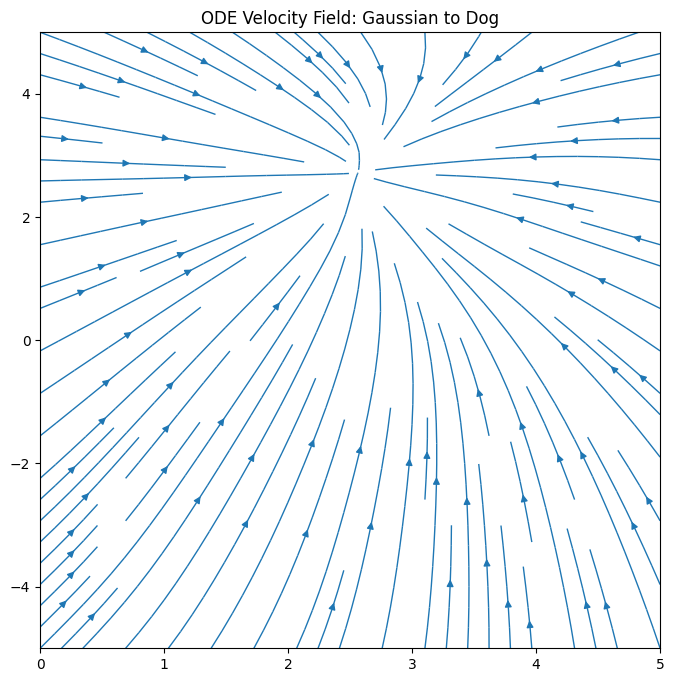

In [ ]:
with torch.no_grad():
    ode_gaussian_result = euler_ode(ode_gaussian_model, gaussians, t, dt)[-1]

ode_gaussian_result_np = ode_gaussian_result.numpy()

plot_distributions_comparison(dogs_np, cats_np, gaussians_np, ode_gaussian_result_np, 'Distribution Comparison: Original vs Gaussian ODE', 'ODE: Gaussian to Dog')
plot_velocity_field(ode_gaussian_model, "ODE Velocity Field: Gaussian to Dog")

***11.*** ***Comparing Performance for ODE vs SDE approch: Gaussian to Dog Mapping***

In [ ]:
import torch
import numpy as np
from scipy.stats import wasserstein_distance
from sklearn.metrics import mean_squared_error
from scipy.stats import entropy

def calculate_kl_divergence(generated, target):

    generated_density = np.histogramdd(generated, bins=10)[0]
    target_density = np.histogramdd(target, bins=10)[0]

    generated_density = generated_density / np.sum(generated_density)
    target_density = target_density / np.sum(target_density)

    kl_divergence = entropy(generated_density, target_density)
    return kl_divergence

def calculate_mse(generated, target):
    return mean_squared_error(generated.numpy(), target.numpy())

def calculate_wasserstein(generated, target):
    return wasserstein_distance(generated[:, 0].numpy(), target[:, 0].numpy()) + \
           wasserstein_distance(generated[:, 1].numpy(), target[:, 1].numpy())

def calculate_histogram_intersection(generated, target, bins=50):
    hist1, _ = np.histogramdd(generated.numpy(), bins=bins)
    hist2, _ = np.histogramdd(target.numpy(), bins=bins)

    minima = np.minimum(hist1, hist2)
    intersection = np.sum(minima)
    return intersection / np.sum(hist1)

# Generate samples
n_samples = 10000
target_dogs = sample_dogs(n_samples)
gaussians = sample_gaussians(n_samples)

# Generate samples using SDE and ODE approaches
with torch.no_grad():
    t = torch.linspace(0, 1, 100)
    dt = t[1] - t[0]

    sde_result = euler_maruyama(sde_model, gaussians, t, dt)[-1]
    ode_result = euler_ode(ode_gaussian_model, gaussians, t, dt)[-1]

# Ensure all results have the same number of samples
min_samples = min(sde_result.shape[0], ode_result.shape[0], target_dogs.shape[0])
sde_result = sde_result[:min_samples]
ode_result = ode_result[:min_samples]
target_dogs = target_dogs[:min_samples]

# Calculate metrics
sde_mse = calculate_mse(sde_result, target_dogs)
ode_mse = calculate_mse(ode_result, target_dogs)

sde_kl_divergence = calculate_kl_divergence(sde_result, target_dogs)
ode_kl_divergence = calculate_kl_divergence(ode_result, target_dogs)

sde_wasserstein = calculate_wasserstein(sde_result, target_dogs)
ode_wasserstein = calculate_wasserstein(ode_result, target_dogs)

sde_histogram_intersection = calculate_histogram_intersection(sde_result, target_dogs)
ode_histogram_intersection = calculate_histogram_intersection(ode_result, target_dogs)


print("SDE Approach:")
print(f"MSE: {sde_mse}")
print(f"KL Divergence: {sde_kl_divergence}")
print(f"Wasserstein Distance: {sde_wasserstein}")
print(f"Histogram Intersection: {sde_histogram_intersection}")

print("\nODE Approach:")
print(f"MSE: {ode_mse}")
print(f"KL Divergence: {ode_kl_divergence}")
print(f"Wasserstein Distance: {ode_wasserstein}")
print(f"Histogram Intersection: {ode_histogram_intersection}")

SDE Approach:
MSE: 0.1033618152141571
KL Divergence: [1.11922857 0.55149284 0.67018236 0.61231871 0.61421464 0.62233013
 0.66826337 0.69925669 0.58691301 0.62463553]
Wasserstein Distance: 0.27012133777141567
Histogram Intersection: 0.325

ODE Approach:
MSE: 0.17018648982048035
KL Divergence: [0.17099368 0.24081554 0.31813801 0.31555496 0.33813085 0.30865046
 0.35949257 0.3518304  0.30612787 0.30374656]
Wasserstein Distance: 0.11237690623998642
Histogram Intersection: 0.4638


***12.*** ***Visualizing Results for Comparison of Performance Metric for SDE vs ODE approach: Gassians to Dogs***

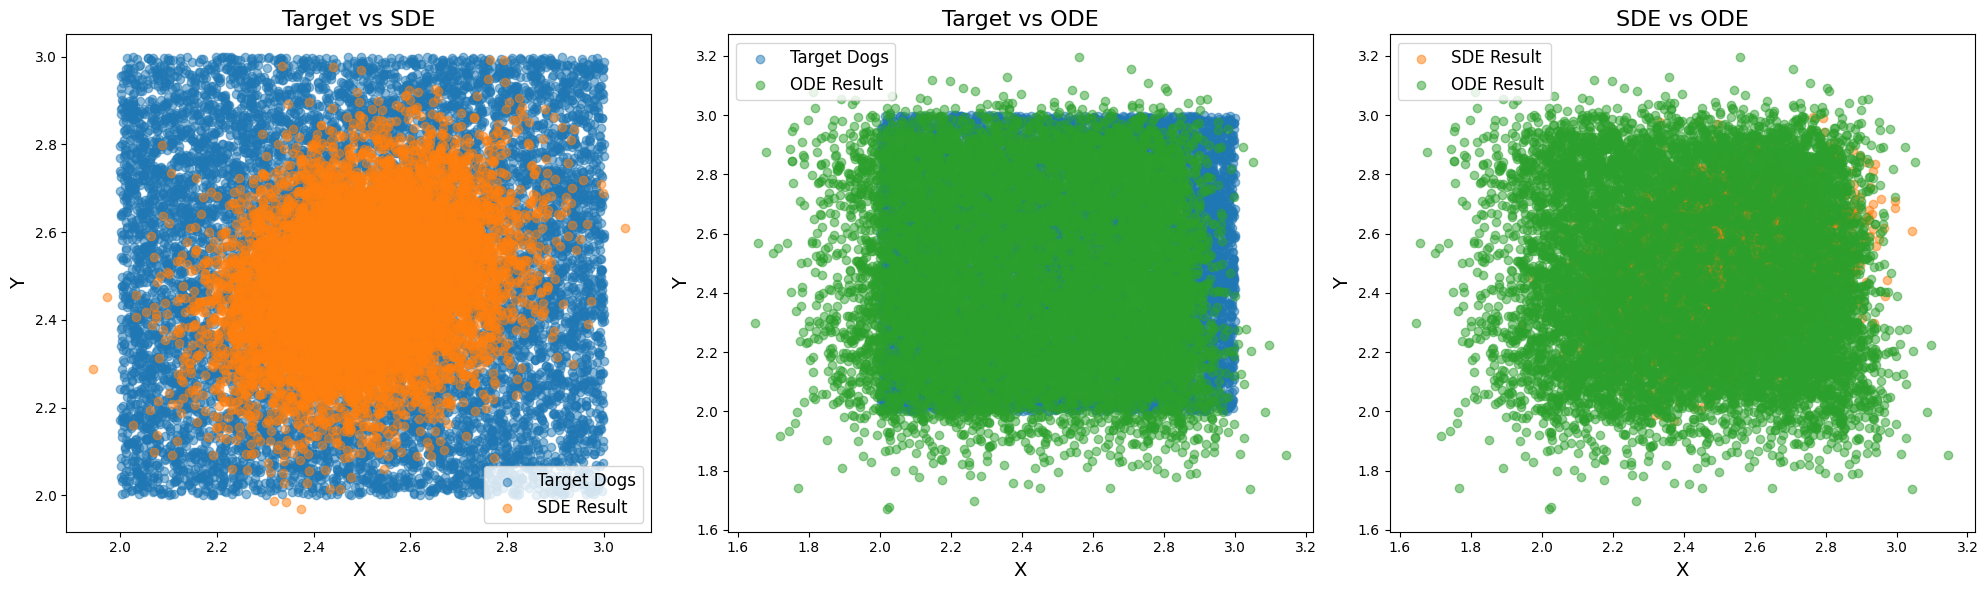

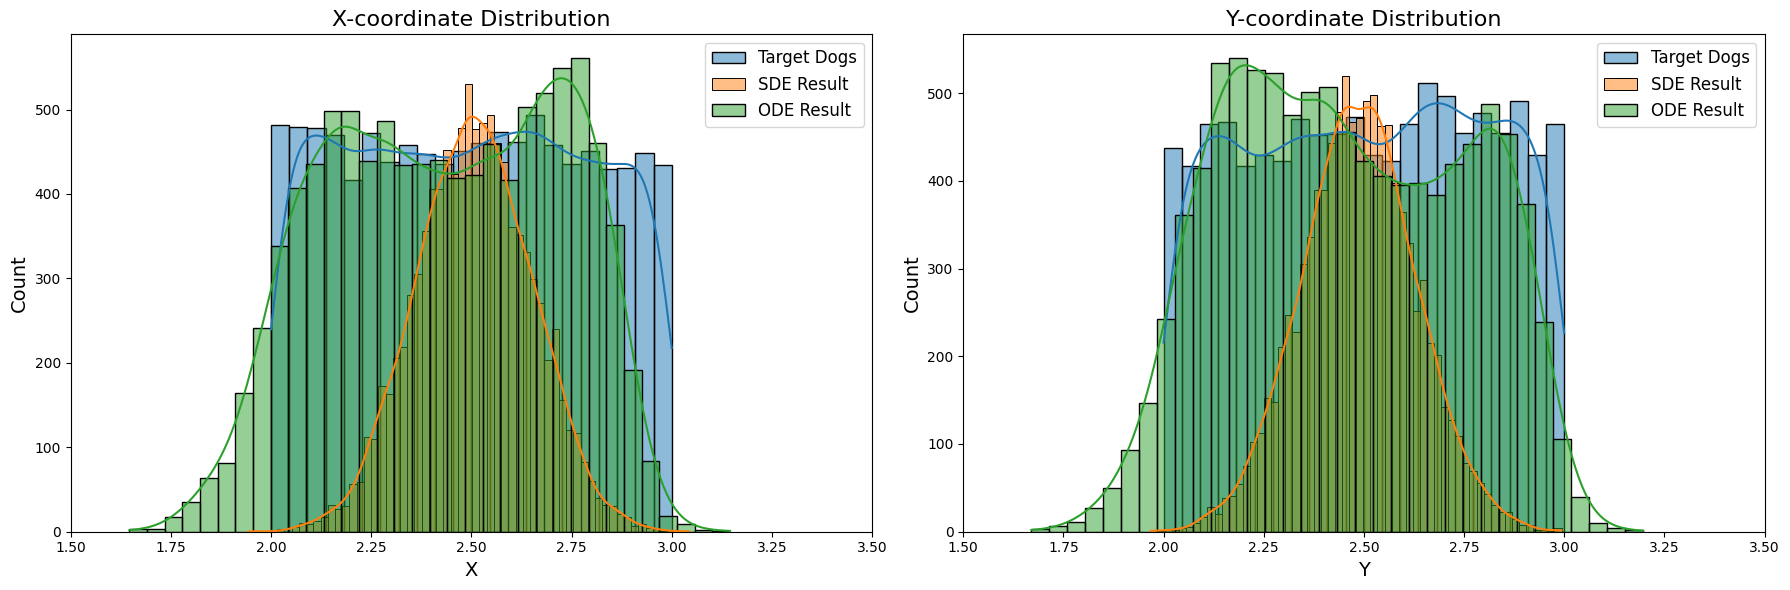

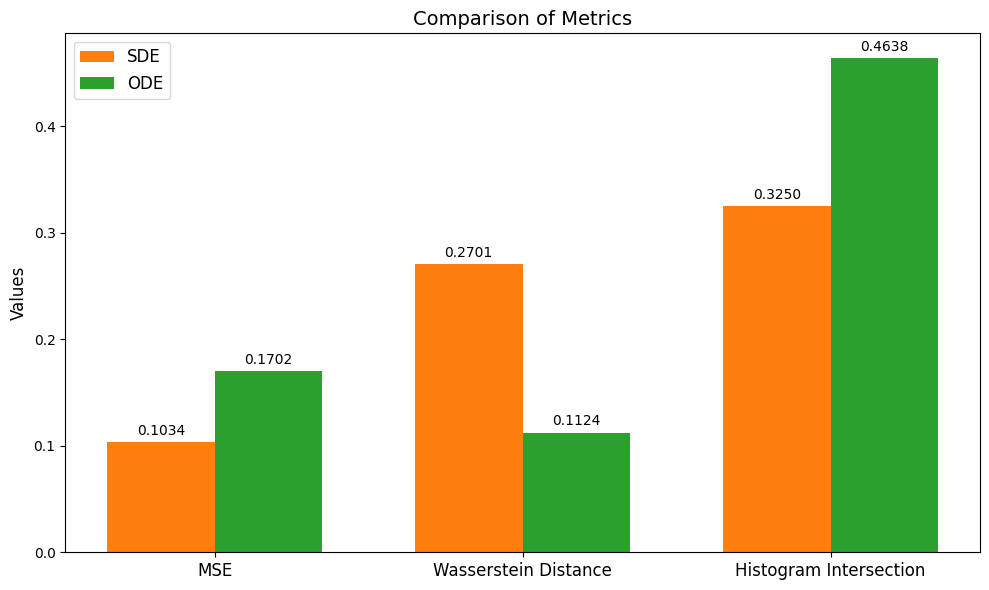

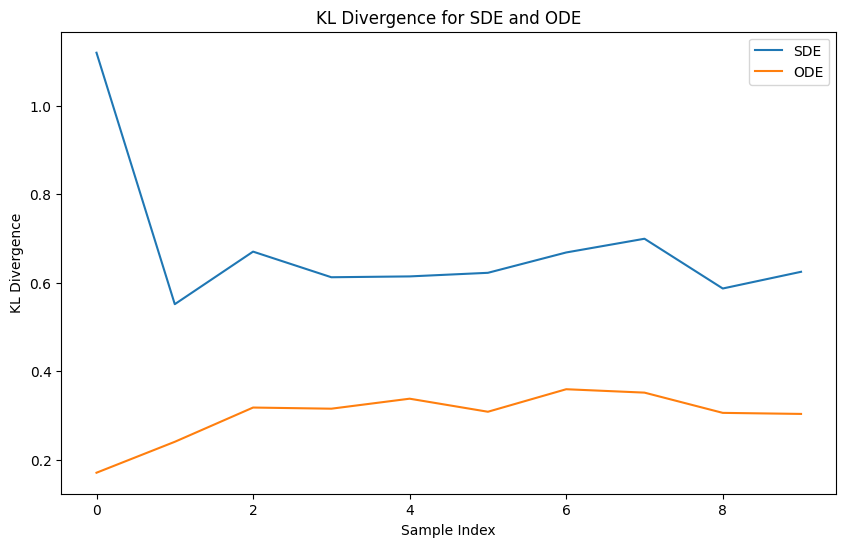

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Custom color palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green

# 1. Distribution Scatter Plot
plt.figure(figsize=(20, 6))

plt.subplot(131)
plt.scatter(target_dogs[:, 0], target_dogs[:, 1], alpha=0.5, label='Target Dogs', color=colors[0])
plt.scatter(sde_result[:, 0], sde_result[:, 1], alpha=0.5, label='SDE Result', color=colors[1])
plt.title('Target vs SDE', fontsize=16)
plt.legend(fontsize=12)
plt.xlabel('X', fontsize=14)
plt.ylabel('Y', fontsize=14)
#plt.xlim(1.5, 3.5)
#plt.ylim(1.5, 3.5)

plt.subplot(132)
plt.scatter(target_dogs[:, 0], target_dogs[:, 1], alpha=0.5, label='Target Dogs', color=colors[0])
plt.scatter(ode_result[:, 0], ode_result[:, 1], alpha=0.5, label='ODE Result', color=colors[2])
plt.title('Target vs ODE', fontsize=16)
plt.legend(fontsize=12)
plt.xlabel('X', fontsize=14)
plt.ylabel('Y', fontsize=14)
#plt.xlim(1.5, 3.5)
#plt.ylim(1.5, 3.5)

plt.subplot(133)
plt.scatter(sde_result[:, 0], sde_result[:, 1], alpha=0.5, label='SDE Result', color=colors[1])
plt.scatter(ode_result[:, 0], ode_result[:, 1], alpha=0.5, label='ODE Result', color=colors[2])
plt.title('SDE vs ODE', fontsize=16)
plt.legend(fontsize=12)
plt.xlabel('X', fontsize=14)
plt.ylabel('Y', fontsize=14)
#plt.xlim(1.5, 3.5)
#plt.ylim(1.5, 3.5)

plt.tight_layout()
plt.show()

# 2. Histogram Comparison
plt.figure(figsize=(18, 6))

plt.subplot(121)
sns.histplot(target_dogs[:, 0], kde=True, label='Target Dogs', color=colors[0], alpha=0.5)
sns.histplot(sde_result[:, 0], kde=True, label='SDE Result', color=colors[1], alpha=0.5)
sns.histplot(ode_result[:, 0], kde=True, label='ODE Result', color=colors[2], alpha=0.5)
plt.title('X-coordinate Distribution', fontsize=16)
plt.legend(fontsize=12)
plt.xlabel('X', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xlim(1.5, 3.5)

plt.subplot(122)
sns.histplot(target_dogs[:, 1], kde=True, label='Target Dogs', color=colors[0], alpha=0.5)
sns.histplot(sde_result[:, 1], kde=True, label='SDE Result', color=colors[1], alpha=0.5)
sns.histplot(ode_result[:, 1], kde=True, label='ODE Result', color=colors[2], alpha=0.5)
plt.title('Y-coordinate Distribution', fontsize=16)
plt.legend(fontsize=12)
plt.xlabel('Y', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xlim(1.5, 3.5)

plt.tight_layout()
plt.show()

# 3. Metrics Comparison Bar Plot
metrics = ['MSE', 'Wasserstein Distance', 'Histogram Intersection']
sde_values = [sde_mse, sde_wasserstein, sde_histogram_intersection]
ode_values = [ode_mse, ode_wasserstein, ode_histogram_intersection]

x = range(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar([i - width/2 for i in x], sde_values, width, label='SDE', color=colors[1])
rects2 = ax.bar([i + width/2 for i in x], ode_values, width, label='ODE', color=colors[2])

ax.set_ylabel('Values', fontsize=12)
ax.set_title('Comparison of Metrics', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.legend(fontsize=12)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', rotation=0, fontsize=10)

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(sde_kl_divergence, label='SDE')
plt.plot(ode_kl_divergence, label='ODE')
plt.title('KL Divergence for SDE and ODE')
plt.xlabel('Sample Index')
plt.ylabel('KL Divergence')
plt.legend()
plt.show()

***13.*** ***Training and plotting loss curve for Cats to Dog ODE approach***

In [ ]:
ode_cat_model = VelocityNet()
ode_cat_optimizer = optim.Adam(ode_cat_model.parameters(), lr=1e-3)
print("\nTraining ODE model (Cat to Dog)...")
losses = train_ode(ode_cat_model, ode_cat_optimizer, n_epochs=5000, batch_size=64, source='cat')
plot_loss_curve(losses, "ODE Training Loss Curve - Cat to Dog")


Training ODE model (Cat to Dog)...
Epoch [100/5000], Loss: 0.1720
Epoch [200/5000], Loss: 0.1812
Epoch [300/5000], Loss: 0.1570
Epoch [400/5000], Loss: 0.1911
Epoch [500/5000], Loss: 0.1254
Epoch [600/5000], Loss: 0.1593
Epoch [700/5000], Loss: 0.1567
Epoch [800/5000], Loss: 0.1323
Epoch [900/5000], Loss: 0.1629
Epoch [1000/5000], Loss: 0.1579
Epoch [1100/5000], Loss: 0.1441
Epoch [1200/5000], Loss: 0.1424
Epoch [1300/5000], Loss: 0.1484
Epoch [1400/5000], Loss: 0.1146
Epoch [1500/5000], Loss: 0.1641
Epoch [1600/5000], Loss: 0.1530
Epoch [1700/5000], Loss: 0.1332
Epoch [1800/5000], Loss: 0.1478
Epoch [1900/5000], Loss: 0.1588
Epoch [2000/5000], Loss: 0.1183
Epoch [2100/5000], Loss: 0.1306
Epoch [2200/5000], Loss: 0.1439
Epoch [2300/5000], Loss: 0.1442
Epoch [2400/5000], Loss: 0.1297
Epoch [2500/5000], Loss: 0.1347
Epoch [2600/5000], Loss: 0.1379
Epoch [2700/5000], Loss: 0.1296
Epoch [2800/5000], Loss: 0.1449
Epoch [2900/5000], Loss: 0.1487
Epoch [3000/5000], Loss: 0.1374
Epoch [3100/5

***14.*** ***Visualizing Results for Cats to Dog: ODE Distribution and Velocity Field***

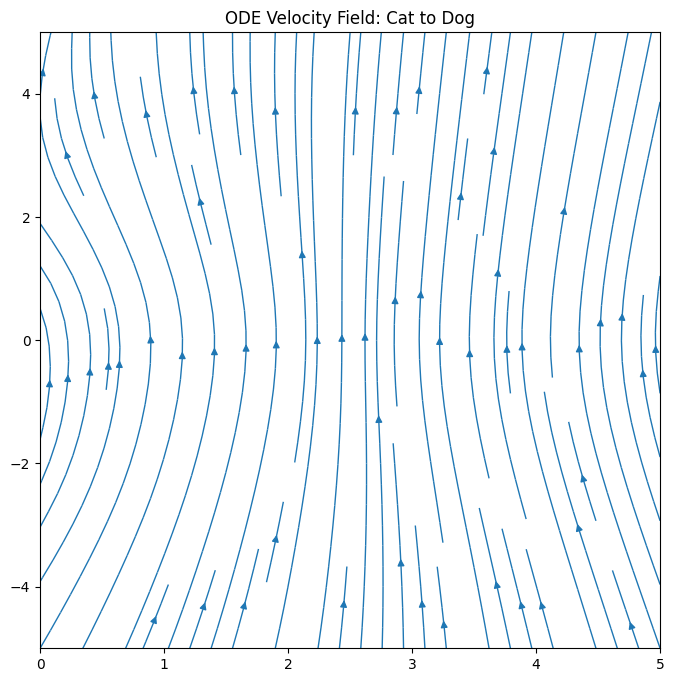

In [ ]:
with torch.no_grad():
    ode_cats_result = euler_ode(ode_cat_model, cats, t, dt)[-1]

ode_cats_result_np = ode_cats_result.numpy()

plot_distributions_comparison(dogs_np, cats_np, gaussians_np, ode_cats_result_np, 'Distribution Comparison: Original vs CAT ODE', 'ODE: Cats to Dogs')
plot_velocity_field(ode_cat_model, "ODE Velocity Field: Cat to Dog")

***15.*** ***Performance Metric for ODE approch: Cats to Dog Mapping***

In [ ]:
n_samples = 10000
#target_dogs = sample_dogs(n_samples)
cats = sample_cats(n_samples)

# Generate samples using SDE and ODE approaches
with torch.no_grad():
    t = torch.linspace(0, 1, 100)
    dt = t[1] - t[0]

    ode_result_cats = euler_ode(ode_cat_model, cats, t, dt)[-1]

# Ensure all results have the same number of samples
min_samples = min(ode_result_cats.shape[0], target_dogs.shape[0])
ode_results_cats = ode_result_cats[:min_samples]
#target_dogs = target_dogs[:min_samples]

# Calculate metrics
ode_mse_cats = calculate_mse(ode_result_cats, target_dogs)
ode_kl_divergence_cats = calculate_kl_divergence(ode_result_cats, target_dogs)
ode_wasserstein_cats = calculate_wasserstein(ode_result_cats, target_dogs)
ode_histogram_intersection_cats = calculate_histogram_intersection(ode_result_cats, target_dogs)

print("\nODE Approach Cats:")
print(f"MSE: {ode_mse_cats}")
print(f"KL Divergence: {ode_kl_divergence_cats}")
print(f"Wasserstein Distance: {ode_wasserstein_cats}")
print(f"Histogram Intersection: {ode_histogram_intersection_cats}")


ODE Approach Cats:
MSE: 0.16324353218078613
KL Divergence: [0.12878239 0.15179689 0.11276963 0.06782949 0.04880478 0.01867303
 0.01426565 0.00993518 0.01551621 0.01799717]
Wasserstein Distance: 0.060766849851608275
Histogram Intersection: 0.673
